### Stroke Work 
#### pooled & site-specific Poisson / Robust Poisson / Negative Binomial
Author: Daniel Maina Nderitu<br>
Project: MADIVA <br>
Site:    Agincourt

### Import libraries

In [115]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px

from scipy import stats

from openpyxl.workbook import Workbook

# see all variables
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Set working directory to where your data and outputs will go
os.chdir(r"D:\APHRC\GoogleDrive_ii\stata_do_files\madiva\stroke_work")
# Ensuring all directories exist
output_dir = r'D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/multiple_records/'
os.makedirs(output_dir, exist_ok=True)
os.makedirs("model_output", exist_ok=True)
os.makedirs("visualization", exist_ok=True)

### Load data

In [116]:
# Loading a cleaned dataset
df_raw = pd.read_csv(
     "D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/data/df_processed_merged_final_agincourt_site.csv",low_memory=False)
df = df_raw.copy()
df = df.copy()
print(df.shape)
# df.head(3)

(32495, 114)


### Data preprocessing

In [117]:
# Drop individuals with only one records
df = df[df['record_type']==2]
print(df.shape)
print(df.sex.value_counts())
df['sex_binary'] = df['sex'].replace({1: 0, 2: 1})  # 0 = male, 1 = female
df['bmi_refined'] = pd.to_numeric(df['bmi_refined'], errors='coerce')
# ------------------------------------------------------------------------------------
# Based on WHO categories
df['bmi_category'] = pd.cut(df['bmi_refined'], 
                            bins=[0, 18.5, 24.9, 29.9, np.inf], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
df = pd.get_dummies(df, columns=['bmi_category'], drop_first=True)

# ------------------------------------------------------------------------------------
# Convert all boolean columns to integers (0/1)
df = df.astype({col: int for col in df.select_dtypes(bool).columns})
df = df.replace([np.inf, -np.inf], np.nan)
print(df.sex_binary.value_counts()) 
# df.head()

(24278, 114)
sex
2    13737
1    10541
Name: count, dtype: int64
sex_binary
1    13737
0    10541
Name: count, dtype: int64


#### SES

In [118]:
# # Wealth index groups
# df['res_hha_wealthtertile'] = df['res_hha_wealthtertile'].replace(-8, np.nan)

# # Treat it as a category
# df['res_hha_wealthtertile'] = df['res_hha_wealthtertile'].astype('category')
# df = df.dropna(subset=['res_hha_wealthtertile'])
# df = pd.get_dummies(df, columns=['res_hha_wealthtertile'], drop_first=True)

# # Filtering to see if the columns exists
# df.filter(like='res_hha_wealthtertile').head()

In [119]:
# Define invalid codes commonly used for 'missing' or 'not applicable'
invalid_codes = [-999, 333, 444, 888, 999, -333, -444, -888]

# Replace invalid codes first
df = df.replace(invalid_codes, np.nan)

# WHO age group coding
def assign_who_age_group_code(age):
    if pd.isnull(age):
        return 999
    elif age < 15:
        return 1
    elif age < 25:
        return 2
    elif age < 65:
        return 3
    else:
        return 4

df["age_group"] = df["age"].apply(assign_who_age_group_code)

age_group_labels = {
    1: "Children (0–14)",
    2: "Youth (15–24)",
    3: "Adults (25–64)",
    4: "Elderly (65+)",
    999: "Missing"
}
df["who_age_group"] = df["age_group"].map(age_group_labels)

# Categorical fill
cat_cols = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived',
            'obese_status_derived', 'diab_status_derived',
            'hiv_status_derived', 'tb_status_derived']

for col in cat_cols:
    df[col] = df[col].fillna('Missing').astype('category')

# Numeric fill
df['bmi_refined'] = df['bmi_refined'].fillna(df['bmi_refined'].median())

# Defragment after all operations
df = df.copy()

#### Site variable (ONE-HOT ENCODING)

In [120]:
# # Making sure 'hdss_name' exists and is string
# df['hdss_name'] = df['hdss_name'].astype(str)
 
# # One-hot encode site (drop one to avoid multicollinearity)
# site_dummies = pd.get_dummies(df['hdss_name'], prefix='site', drop_first=True)
# print(site_dummies.columns.tolist())

# # Merge dummy columns into df
# df = pd.concat([df, site_dummies], axis=1)
# df['site_Nairobi'] = df['site_Nairobi'].astype('category')
# # df['site_Agincourt'] = df['site_Agincourt'].astype('category')

# print("Site dummy variables created:", list(site_dummies.columns))
# # df.head(3)

#### To integer type

In [121]:
# df.site_Nairobi = df.site_Nairobi.astype(int)

df.bmi_category_Normal = df.bmi_category_Normal.astype(int)
df.bmi_category_Overweight = df.bmi_category_Overweight.astype(int)
df.bmi_category_Obese = df.bmi_category_Obese.astype(int)
# df.hdss_name.value_counts()

### Event, time_at_risk (person-years), covariates <br>

Treatment to ensure we don't inflate incidence

Before
(24278, 120)
Missing time_at_risk before imputation: 0 (0.00%)


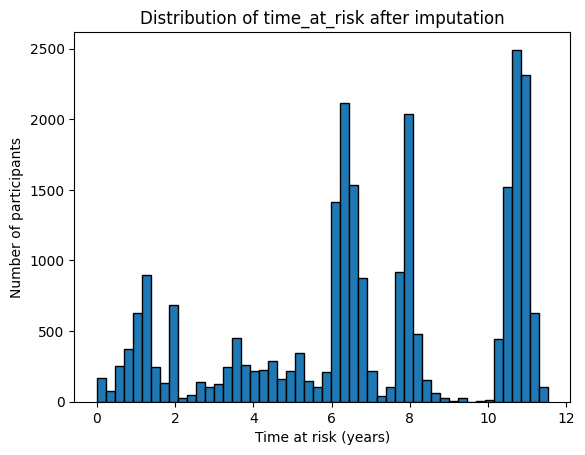

In [122]:
print("Before")
print(df.shape)

# including only periods where the person is under observation — between entry-type events and exit-type events.
# valid_events = ['enumeration', 'birth', 'inmigration', 'entry', 'exit', 'death', 'outmigration', 'OBE', 'time-varying covariate']
# valid_events = [ -2, -1, 1, 2, 4, 6] #  10   (Entry events)
# df = df[df['res_event'].isin(valid_events)].copy()

# ---------------------------------------------------------------------------
# df['res_eventdate'] = pd.to_datetime(df['res_eventdate'], errors='coerce')
# Convert obs_date from string (e.g., '26jul2008') to datetime
df['obs_date'] = pd.to_datetime(df['obs_date'], format='%d%b%Y', errors='coerce')

# ---------------------------------------------------------------------------
# Sorting based on an individual and observation date
df = df.sort_values(['individual_id', 'obs_date'])

# ---------------------------------------------------------------------------
# Preparing time intervals during which a person is at risk
df['start_date'] = df.groupby('individual_id')['obs_date'].transform('min')
df['end_date'] = df.groupby('individual_id')['obs_date'].transform('max')

# ---------------------------------------------------------------------------
# Computing time at risk (person-time) in years
df['time_at_risk'] = (df['end_date'] - df['start_date']).dt.days / 365.25
df['time_at_risk'] = df['time_at_risk'].fillna(df['time_at_risk'].median()) # df['time_at_risk'] = df['time_at_risk'].fillna(1.5) 

# ---------------------------------------------------------------------------
missing_time_count = df['time_at_risk'].isna().sum()
total_count = len(df)
missing_percent = (missing_time_count / total_count) * 100

print(f"Missing time_at_risk before imputation: {missing_time_count:,} ({missing_percent:.2f}%)")

# If you have a site variable, examine missingness by site
if 'site' in df.columns:
    missing_by_site = df.groupby('hdss_name')['time_at_risk'].apply(lambda x: x.isna().mean() * 100).round(2)
    print("\nMissing time_at_risk by site (%):")
    print(missing_by_site)

# Optional: visualize distribution after imputation
import matplotlib.pyplot as plt

plt.hist(df['time_at_risk'], bins=50, edgecolor='black')
plt.xlabel("Time at risk (years)")
plt.ylabel("Number of participants")
plt.title("Distribution of time_at_risk after imputation")
plt.show()
# ---------------------------------------------------------------------------

# # df = df.apply(pd.to_numeric, errors='coerce')
# df['time_at_risk'] = pd.to_numeric(df['time_at_risk'], errors='coerce')

# ---------------------------------------------------------------------------
df.loc[df['time_at_risk'] < 0.01, 'time_at_risk'] = 0.01  # avoid log(0)  [Doing some house cleaning to avoid negative offset values]

# ---------------------------------------------------------------------------
# Creating offset (Added a tiny constant (epsilon) since I was encountering some negative offset values. This is a robust and common approach in survival and Poisson models.)
df['offset'] = np.log(df['time_at_risk']) #.clip(lower=1e-6)) 

# ---------------------------------------------------------------------------
# Defining stroke event (stroke occurrence)
# df['stroke_prev'] = df.groupby('individual_id')['stroke_status_derived'].shift(1)
df['stroke_prev'] = df.groupby('individual_id')['stroke_status_derived'].shift(1).fillna(0) # A great assumption here (people didn't have stroke previously)
df['event'] = np.where((df['stroke_prev'] == 0) & (df['stroke_status_derived'] == 1), 1, 0)
df['event'] = df['event'].fillna(0)

# ---------------------------------------------------------------------------
# finding first event per person  (different from prevalence)
df['cumulative_stroke'] = df.groupby('individual_id')['stroke_status_derived'].cumsum()
# keeping only records before or up to the first stroke
df = df[df['cumulative_stroke'] <= 1]

#### Visualization the distribution of time_at_risk

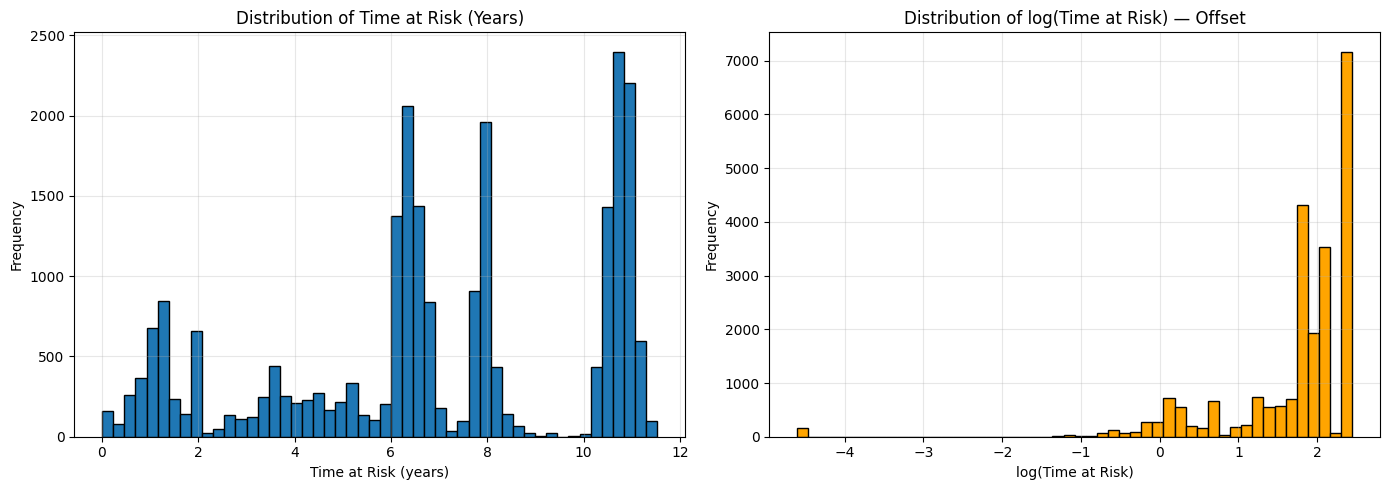

In [123]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))

# Raw distribution
plt.subplot(1, 2, 1)
plt.hist(df['time_at_risk'], bins=50, edgecolor='k')
plt.title('Distribution of Time at Risk (Years)')
plt.xlabel('Time at Risk (years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Log-transformed (offset)
plt.subplot(1, 2, 2)
plt.hist(np.log(df['time_at_risk'][df['time_at_risk'] > 0]), bins=50, edgecolor='k', color='orange')
plt.title('Distribution of log(Time at Risk) — Offset')
plt.xlabel('log(Time at Risk)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
fig_path = os.path.join(output_dir, 'Agincourt_site_specific_time_at_risk_dist.png')
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

#### Summary

In [124]:
# Descriptive statistics for time_at_risk
summary = df['time_at_risk'].describe(percentiles=[0.25, 0.5, 0.75])
print(summary)

# Optionally show only relevant values neatly formatted
median = summary['50%']
iqr_low = summary['25%']
iqr_high = summary['75%']

print(f"Median time at risk = {median:.2f} years (IQR: {iqr_low:.2f} – {iqr_high:.2f})")


count    23434.000000
mean         6.930532
std          3.274788
min          0.010000
25%          5.059548
50%          6.754278
75%         10.535250
max         11.526352
Name: time_at_risk, dtype: float64
Median time at risk = 6.75 years (IQR: 5.06 – 10.54)


In [125]:
# df.query('time_at_risk < 0.01')[['individual_id', 'start_date', 'end_date', 'time_at_risk']].head(10)
df.loc[df['time_at_risk'] < 0.01, 'time_at_risk'] = 0.01
# df['offset'] = np.log(df['time_at_risk'])

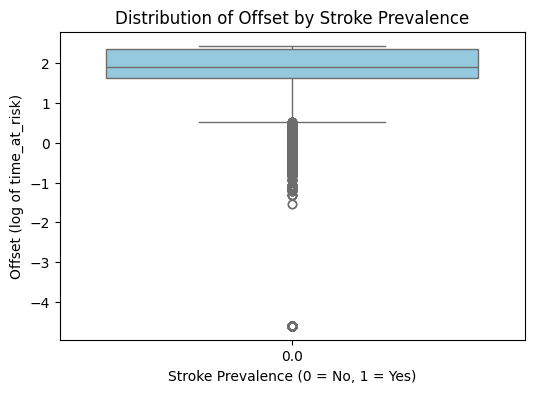

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    data=df,
    x='stroke_prev',
    y='offset',
    hue='stroke_prev',
    palette={0: 'skyblue', 1: 'salmon'},
    legend=False
)
plt.title('Distribution of Offset by Stroke Prevalence')
plt.xlabel('Stroke Prevalence (0 = No, 1 = Yes)')
plt.ylabel('Offset (log of time_at_risk)')
plt.show()


In [127]:
print((df['time_at_risk'] <= 0).sum())  # Checking time values that dont make sense
# df.loc[df['time_at_risk'] < 0.01, ['individual_id', 'res_event', 'start_date', 'end_date', 'time_at_risk','offset']].head(50)

0


#### individuals with stroke transition

In [128]:
# Identify individuals who experienced a stroke (event == 1)
stroke_cases = df[df['event'] == 1]['individual_id'].unique()

# Subset full data for only those individuals
df_stroke_transition = df[df['individual_id'].isin(stroke_cases)]

In [129]:
selected = ['individual_id', 'start_date', 'end_date', 'stroke_prev', 'event'
            , 'time_at_risk', 'cumulative_stroke', 'offset'] # , 'res_eventdate'

check_df = df_stroke_transition[selected].sort_values(['individual_id', 'start_date']).head(20)
check_df.head(10) # , 'res_eventdate' (replaced , 'res_eventdate' with 'start_date' )

,individual_id,start_date,end_date,stroke_prev,event,time_at_risk,cumulative_stroke,offset
25,BBCZP,2013-10-07,2015-09-01,0.0,1,1.900068,1.0,0.641890
219,BCKLZ,2010-09-22,2015-01-22,0.0,0,4.334018,0.0,1.466495
220,BCKLZ,2010-09-22,2015-01-22,0.0,0,4.334018,0.0,1.466495
221,BCKLZ,2010-09-22,2015-01-22,0.0,1,4.334018,1.0,1.466495
304,BCVBF,2013-10-30,2015-09-17,0.0,1,1.880903,1.0,0.631752
357,BDBRY,2010-09-10,2021-09-15,0.0,0,11.014374,0.0,2.399201
358,BDBRY,2010-09-10,2021-09-15,0.0,0,11.014374,0.0,2.399201
359,BDBRY,2010-09-10,2021-09-15,0.0,0,11.014374,0.0,2.399201
360,BDBRY,2010-09-10,2021-09-15,0.0,1,11.014374,1.0,2.399201
422,BDOVZ,2015-06-29,2021-11-18,0.0,0,6.390144,0.0,1.854757


#### Visualization of time at risk

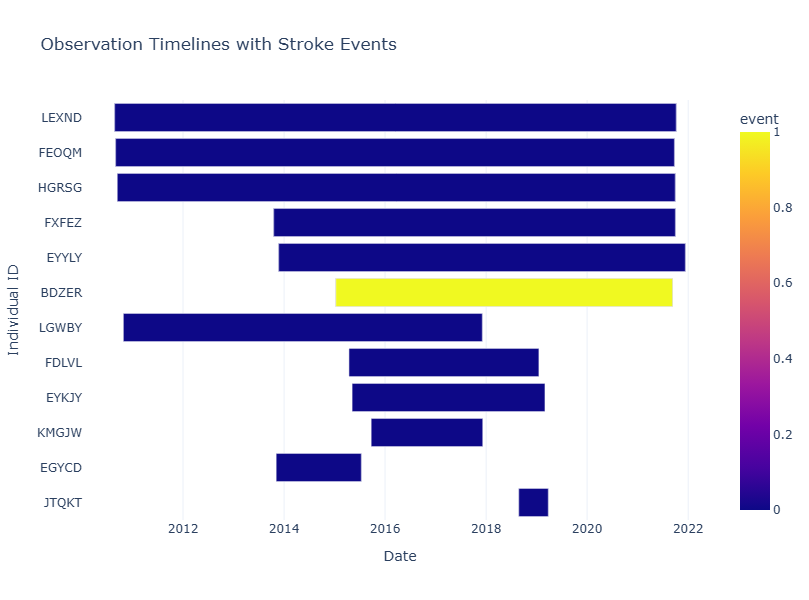

In [130]:
# Get unique IDs
unique_ids = df['individual_id'].drop_duplicates()

# Adjust sample size to the number of available individuals
sample_size = min(12, len(unique_ids))

# Take sample safely
sample_ids = unique_ids.sample(sample_size, random_state=42)

# Filter dataset for those individuals
df_sample = df[df['individual_id'].isin(sample_ids)]

# ---------------------------------------------------------------------------
# Create timeline visualization
fig = px.timeline(
    df_sample,
    x_start="start_date",
    x_end="end_date",
    y="individual_id",
    color="event",
    color_discrete_map={0: "skyblue", 1: "red"},
    title="Observation Timelines with Stroke Events",
)

# Update layout
fig.update_yaxes(title="Individual ID", categoryorder="total ascending")
fig.update_xaxes(title="Date")
fig.update_layout(
    legend_title_text="Stroke Event (1=Yes, 0=No)",
    template="plotly_white",
    height=600,
)

# Show interactive figure
fig.show()

### Covariates and dealing with infinite values

In [131]:
# df = df.fillna(0)  # or use .fillna(df.mean()) if numeric

covariates = ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese' ,'hiv_status_derived', 'tb_status_derived'] #  + list(site_dummies.columns) 
# , 'res_hha_wealthtertile_2.0', 'res_hha_wealthtertile_3.0'  # (Will add these once we obtain these data points)

# predictors to display in forest plots/compare across sites
key_predictors = ['hpt_status_derived', 'diab_status_derived', 'tb_status_derived'] # , 'site_Nairobi'
# 'sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_refined','hiv_status_derived', 'tb_status_derived'

print(df.offset.describe())
print(df.shape)

count    23434.000000
mean         1.709822
std          0.900582
min         -4.605170
25%          1.621277
50%          1.910176
75%          2.354727
max          2.444636
Name: offset, dtype: float64
(23434, 127)


### Cleaning & checks (event, time_at_risk, site)

In [132]:
# Ensuring required columns exist
required = ['event', 'time_at_risk', 'hdss_name'] + covariates
missing_cols = [c for c in required if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in df: {missing_cols}")

# dropping rows with non-positive time_at_risk
df = df.copy()
df = df[df['time_at_risk'].notna()]
df = df[df['time_at_risk'] > 0]

# Ensuring hdss_name entries are strings and consistent
df['hdss_name'] = df['hdss_name'].astype(str).str.strip()

# Creating site dummies; Agincourt is the reference site -> drop_first=True will drop first alphabetically by default
# We'll create specifically site_Nairobi and site_Agincourt if needed and ensure Agincourt is reference
sites = df['hdss_name'].unique().tolist()
print("Sites found:", sites)

# create dummies and keep only 'site_Nairobi' as dummy (Agincourt reference)
site_dummies = pd.get_dummies(df['hdss_name'], prefix='site')
# If both created, drop 'site_Agincourt' to make it reference
if 'site_Nairobi' in site_dummies.columns:
    if 'site_Agincourt' not in site_dummies.columns:
        # make sure Nairobi present; handle gracefully if not
        pass
    site_cols = [c for c in site_dummies.columns if c != 'site_Nairobi']
else:
    site_cols = [c for c in site_dummies.columns]  # in case naming differs
# attach to df
df = pd.concat([df, site_dummies], axis=1)

# If site_Nairobi exists and Agincourt exists then site_Agincourt being absent from X implies Agincourt reference
print("Site dummy columns:", [c for c in site_cols if c in df.columns])
print(df.shape)
# df.head(20)

Sites found: ['Agincourt']
Site dummy columns: ['site_Agincourt']
(23434, 128)


### Offset for pooled models

In [133]:
# -----------------------------
# 2. Prepare X, y, offset for pooled models
# -----------------------------

def prepare_pooled_data(df, covariates, event_col='event', offset_col='offset'):
    """
    Prepare data for pooled regression models, handling 'Missing' string values.
    """
    
    # Select only covariates that exist in df (defensive)
    covariates_present = [c for c in covariates if c in df.columns]
    missing_covariates = set(covariates) - set(covariates_present)
    
    if missing_covariates:
        print(f"⚠️  Warning: Missing covariates: {missing_covariates}")
    print("✅ Covariates used:", covariates_present)
    
    # Create working copies
    X_pooled = df[covariates_present].copy()
    y = df[event_col].copy()
    offset = df[offset_col].copy()
    
    # --- First: Convert 'Missing' strings to NaN ---
    print("🔄 Converting 'Missing' strings to NaN...")
    
    for col in X_pooled.columns:
        # Check if column contains string 'Missing'
        if X_pooled[col].dtype == 'object':
            missing_count = (X_pooled[col] == 'Missing').sum()
            if missing_count > 0:
                print(f"   {col}: {missing_count} 'Missing' values → NaN")
                X_pooled[col] = X_pooled[col].replace('Missing', np.nan)
        
        # Also check for other missing representations
        other_missing_representations = ['missing', 'MISSING', 'Unknown', 'unknown', '']
        if X_pooled[col].dtype == 'object':
            for missing_val in other_missing_representations:
                if missing_val in X_pooled[col].values:
                    count = (X_pooled[col] == missing_val).sum()
                    if count > 0:
                        print(f"   {col}: {count} '{missing_val}' values → NaN")
                        X_pooled[col] = X_pooled[col].replace(missing_val, np.nan)
    
    # --- Now handle data types properly ---
    print("🔄 Converting data types...")
    
    for col in X_pooled.columns:
        if X_pooled[col].dtype == 'bool':
            # Convert pure boolean to int
            X_pooled[col] = X_pooled[col].astype(int)
            print(f"   {col}: bool → int")
            
        elif X_pooled[col].dtype == 'object':
            # Try to convert to numeric, which will handle the NaN values properly
            original_dtype = X_pooled[col].dtype
            X_pooled[col] = pd.to_numeric(X_pooled[col], errors='coerce')
            converted_nans = X_pooled[col].isna().sum()
            print(f"   {col}: {original_dtype} → numeric ({converted_nans} NaN values)")
            
        else:
            # Ensure numeric type
            original_dtype = X_pooled[col].dtype
            X_pooled[col] = pd.to_numeric(X_pooled[col], errors='coerce')
            if X_pooled[col].dtype != original_dtype:
                print(f"   {col}: {original_dtype} → {X_pooled[col].dtype}")
    
    # --- Check missingness percentage after conversion ---
    check_columns = covariates_present + [event_col, offset_col]
    missing_pct = (
        pd.concat([X_pooled, y.rename('event'), offset.rename('offset')], axis=1)
        .isna()
        .mean()
        .sort_values(ascending=False) * 100
    )
    
    print("\n🔎 Final percentage of missing values by variable:")
    for var, pct in missing_pct[missing_pct > 0].items():
        print(f"   {var}: {pct:.2f}%")
    
    if missing_pct.max() == 0:
        print("   No missing values found.")
    
    # --- Drop only rows where outcome or offset are missing or invalid ---
    valid_mask = (
        y.notna() & 
        np.isfinite(offset) & 
        (y >= 0)  # Assuming events should be non-negative
    )
    
    n_initial = len(df)
    n_final = valid_mask.sum()
    n_dropped = n_initial - n_final
    
    if n_dropped > 0:
        print(f"📊 Dropped {n_dropped} rows ({n_dropped/n_initial*100:.1f}%) due to missing/invalid outcomes or offsets")
    
    # Apply the mask
    X_pooled = X_pooled.loc[valid_mask]
    y_pooled = y.loc[valid_mask]
    offset_pooled = offset.loc[valid_mask]
    
    # --- Add constant term ---
    X_pooled_const = sm.add_constant(X_pooled, has_constant='add')
    
    print(f"\n✅ Final pooled dataset: {X_pooled_const.shape[0]} rows, {X_pooled_const.shape[1]} columns")
    print(f"   Features: {X_pooled_const.shape[1]-1} covariates + constant")
    
    return X_pooled_const, y_pooled, offset_pooled, covariates_present

# Usage
covariates_present = [c for c in covariates if c in df.columns]
print("Covariates used:", covariates_present)

X_pooled_const, y_pooled, offset_pooled, covariates_used = prepare_pooled_data(df, covariates_present)

# Verify the result
print("\n🔍 Sample of processed X_pooled:")
print(X_pooled_const.head())
print(f"\nData types:\n{X_pooled_const.dtypes}")

Covariates used: ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived', 'obese_status_derived', 'diab_status_derived', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'hiv_status_derived', 'tb_status_derived']
✅ Covariates used: ['sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived', 'obese_status_derived', 'diab_status_derived', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'hiv_status_derived', 'tb_status_derived']
🔄 Converting 'Missing' strings to NaN...
🔄 Converting data types...
   sex_binary: category → int64
   alcohol_use: category → float64
   tobacco_use: category → float64
   hpt_status_derived: category → float64
   obese_status_derived: category → float64
   diab_status_derived: category → float64
   hiv_status_derived: category → float64
   tb_status_derived: category → float64

🔎 Final percentage of missing values by variable:
   alcohol_use: 75.11%
   tb_status_derived: 32.91%
   obese_status_deriv

In [135]:
# 'sex_binary', 'alcohol_use', 'tobacco_use', 'hpt_status_derived','obese_status_derived', 'diab_status_derived','bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese' ,'hiv_status_derived', 'tb_status_derived', 'res_hha_wealthtertile_2.0', 'res_hha_wealthtertile_3.0'
# df['res_hha_wealthtertile_3.0'].value_counts()

### Fit pooled models

In [136]:
# # -------------------------------------------------------------------------------------------------------
# # Initial Approach
# # -------------------------------------------------------------------------------------------------------
# # Ensure no missing or infinite values remain in predictors or offset
# mask_valid = (
#     X_pooled_const.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) &
#     np.isfinite(offset_pooled) &
#     y_pooled.notna()
# )

# X_model = X_pooled_const.loc[mask_valid].copy()
# y_model = y_pooled.loc[mask_valid].copy()
# offset_model = offset_pooled.loc[mask_valid].copy()

# print("✅ Rows used after final cleaning:", X_model.shape[0])
# print("Dropped rows due to NaN/Inf:", (~mask_valid).sum())

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -----------------------------------------------------
# 🧹 Impute missing values BEFORE dropping rows
# -----------------------------------------------------
X_pooled_const = X_pooled_const.replace([np.inf, -np.inf], np.nan)

# Fill boolean / binary columns with 0 (assuming False or 'No')
binary_cols = [c for c in X_pooled_const.columns if X_pooled_const[c].dropna().nunique() <= 2]
X_pooled_const[binary_cols] = X_pooled_const[binary_cols].fillna(0)

# Fill numeric columns with their mean
numeric_cols = [c for c in X_pooled_const.columns if c not in binary_cols]
X_pooled_const[numeric_cols] = X_pooled_const[numeric_cols].fillna(X_pooled_const[numeric_cols].mean())

# Offset — replace invalid values with mean offset (rare case)
offset_pooled = offset_pooled.replace([np.inf, -np.inf], np.nan).fillna(offset_pooled.mean())

# Now define valid mask — only check y (event) and offset
mask_valid = y_pooled.notna() & np.isfinite(offset_pooled)

X_model = X_pooled_const.loc[mask_valid].copy()
y_model = y_pooled.loc[mask_valid].copy()
offset_model = offset_pooled.loc[mask_valid].copy()

print("✅ Rows used after imputation and cleaning:", X_model.shape[0])

# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------



✅ Rows used after imputation and cleaning: 23434


In [137]:
# -----------------------------
# 3. Fit pooled models
# -----------------------------
print("\nFitting pooled Poisson...")
model_pois = sm.GLM(y_model, X_model, family=sm.families.Poisson(), offset=offset_model).fit()
print(model_pois.summary())

print("\nFitting pooled Robust Poisson (HC0)...")
model_robust = sm.GLM(y_model, X_model, family=sm.families.Poisson(), offset=offset_model).fit(cov_type='HC0')
print(model_robust.summary())

print("\nFitting pooled Negative Binomial...")
model_nb = sm.GLM(y_model, X_model, family=sm.families.NegativeBinomial(), offset=offset_model).fit()
print(model_nb.summary())


# -----------------------------
# 4. Create a results dataframe
# -----------------------------
def extract_results(model, model_name):
    params = model.params
    conf = model.conf_int()
    conf.columns = ['CI_lower', 'CI_upper']
    results_df = pd.DataFrame({
        'coef': params,
        'se': model.bse,
        'p': model.pvalues,
    })
    results_df = pd.concat([results_df, conf], axis=1)
    results_df['IRR'] = np.exp(results_df['coef'])
    results_df['IRR_CI_lower'] = np.exp(results_df['CI_lower'])
    results_df['IRR_CI_upper'] = np.exp(results_df['CI_upper'])
    results_df['Model'] = model_name
    return results_df.reset_index().rename(columns={'index': 'Variable'})

# Extract results for all models
df_pois = extract_results(model_pois, "Poisson")
df_robust = extract_results(model_robust, "Robust Poisson (HC0)")
df_nb = extract_results(model_nb, "Negative Binomial")

# Combine all results
all_results = pd.concat([df_pois, df_robust, df_nb], ignore_index=True)

# -----------------------------
# 5. Export to Excel
# -----------------------------
excel_path = "multiple_records/Agincourt_pooled_model_results.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    df_pois.to_excel(writer, sheet_name="Poisson", index=False)
    df_robust.to_excel(writer, sheet_name="Robust_Poisson", index=False)
    df_nb.to_excel(writer, sheet_name="NegBinomial", index=False)
    all_results.to_excel(writer, sheet_name="All_Models_Combined", index=False)

print(f"\n✅ Results exported successfully to: {excel_path}")



Fitting pooled Poisson...
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                23434
Model:                            GLM   Df Residuals:                    23422
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2419.7
Date:                Tue, 18 Nov 2025   Deviance:                       3829.3
Time:                        12:13:43   Pearson chi2:                 1.56e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005731
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.



                 Generalized Linear Model Regression Results                  
Dep. Variable:                  event   No. Observations:                23434
Model:                            GLM   Df Residuals:                    23422
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2425.7
Date:                Tue, 18 Nov 2025   Deviance:                       3451.3
Time:                        12:13:44   Pearson chi2:                 1.55e+05
No. Iterations:                     7   Pseudo R-squ. (CS):           0.005621
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Dispersion and model comparison

In [138]:
# -----------------------------
# 4. Dispersion & model comparison
# -----------------------------
def dispersion(model):
    return model.pearson_chi2 / model.df_resid

disp_pois = dispersion(model_pois)
disp_nb = dispersion(model_nb)
print(f"\nPooled Poisson dispersion (Pearson chi2 / df): {disp_pois:.3f}")
print(f"Pooled NB dispersion (Pearson chi2 / df): {disp_nb:.3f}")

comparison = pd.DataFrame({
    'model': ['Poisson', 'RobustPoisson', 'NegBinomial'],
    'AIC': [model_pois.aic, model_robust.aic if hasattr(model_robust, 'aic') else np.nan, model_nb.aic],
    'LogLik': [model_pois.llf, model_robust.llf if hasattr(model_robust, 'llf') else np.nan, model_nb.llf],
    'Dispersion': [disp_pois, np.nan, disp_nb]
})
print("\nModel comparison:\n", comparison)


Pooled Poisson dispersion (Pearson chi2 / df): 6.666
Pooled NB dispersion (Pearson chi2 / df): 6.623

Model comparison:
            model          AIC       LogLik  Dispersion
0        Poisson  4863.339600 -2419.669800    6.666123
1  RobustPoisson  4863.339600 -2419.669800         NaN
2    NegBinomial  4875.499958 -2425.749979    6.622612


In [139]:
print(df['time_at_risk'].describe())
print(df['offset'].describe())
df['site_Agincourt'].value_counts(dropna=False)

count    23434.000000
mean         6.930532
std          3.274788
min          0.010000
25%          5.059548
50%          6.754278
75%         10.535250
max         11.526352
Name: time_at_risk, dtype: float64
count    23434.000000
mean         1.709822
std          0.900582
min         -4.605170
25%          1.621277
50%          1.910176
75%          2.354727
max          2.444636
Name: offset, dtype: float64


site_Agincourt
True    23434
Name: count, dtype: int64

### Interaction test
Adding interactions between site_Nairobi and each covariate in covariates present

In [140]:
# # -----------------------------
# # 5. Interaction test: site x covariate(s)
# #    We'll add interactions between site_Nairobi and each covariate in covariates_present
# # -----------------------------
# # Only create interactions if site_Nairobi exists
# site_dummy = 'site_Nairobi' if 'site_Nairobi' in df.columns else None
# if site_dummy is None:
#     print("Warning: site_Nairobi column not found; skipping interactions.")
# else:
#     print("\nBuilding pooled model with site interactions (Poisson)...")
#     X_int = X_pooled.copy()
#     # -------------------------------------------------------------------
#     print(df['site_Nairobi'].unique())
#     print(df['site_Nairobi'].isna().sum())
#     # -------------------------------------------------------------------
#     inter_cols = []
#     for c in covariates_present:
#         inter_name = f"{c}_x_{site_dummy}"
#         X_int[inter_name] = X_int[c] * df.loc[X_int.index, site_dummy]
#         inter_cols.append(inter_name)
#     X_int_const = sm.add_constant(X_int, has_constant='add')
#     # align offset and y
#     offset_int = offset_pooled.loc[X_int_const.index]
#     y_int = y_pooled.loc[X_int_const.index]

#     model_int = sm.GLM(y_int, X_int_const, family=sm.families.Poisson(), offset=offset_int).fit()
#     print(model_int.summary())

#     # LR test comparing base pooled Poisson vs model_int
#     llf_base = model_pois.llf
#     llf_full = model_int.llf
#     df_diff = model_int.df_model - model_pois.df_model
#     lr_stat = 2 * (llf_full - llf_base)
#     p_lr = 1 - stats.chi2.cdf(lr_stat, df_diff)
#     print(f"\nInteraction LR test: chi2={lr_stat:.2f}, df={df_diff}, p={p_lr:.4g}")

### Site-specific models (Poisson and NB) and IRR extracts

In [141]:
# -----------------------------
# 6. Site-specific models (Poisson and NB) and extract IRRs
# -----------------------------
site_models = {}
site_results = []
for site in df['hdss_name'].unique():
    dfi = df[df['hdss_name'] == site].copy()
    # ensure positive time at risk and enough rows
    dfi = dfi[dfi['time_at_risk'] > 0]
    n = dfi.shape[0]
    events = dfi['event'].sum()
    print(f"\nSite: {site}  n={n}  events={events}")
    if n < 50 or events < 5:
        print(f"  Skipping site {site} due to small n or few events (n={n}, events={events})")
        continue

    Xi = dfi[covariates_present].copy()
    # booleans->int
    bool_cols_site = Xi.select_dtypes(include=['bool']).columns.tolist()
    for c in bool_cols_site:
        Xi[c] = Xi[c].astype(int)
    Xi = Xi.apply(pd.to_numeric, errors='coerce')

    yi = dfi['event'].copy()
    offi = np.log(dfi['time_at_risk'].astype(float))

    mask_i = Xi.notna().all(axis=1) & yi.notna() & np.isfinite(offi)
    Xi = Xi.loc[mask_i]
    yi = yi.loc[mask_i]
    offi = offi.loc[mask_i]
    Xi_const = sm.add_constant(Xi, has_constant='add')

    try:
        mod_p = sm.GLM(yi, Xi_const, family=sm.families.Poisson(), offset=offi).fit()
        mod_nb = sm.GLM(yi, Xi_const, family=sm.families.NegativeBinomial(), offset=offi).fit()
    except Exception as e:
        print(f"  Models failed for site {site}: {e}")
        continue

    site_models[site] = {'poisson': mod_p, 'nb': mod_nb}

    # extract IRRs and CIs for key covariates
    for mname, m in [('Poisson', mod_p), ('NegBinomial', mod_nb)]:
        res_df = pd.DataFrame({
            'site': site,
            'Model': mname,
            'Variable': m.params.index,
            'coef': m.params.values,
            'se': m.bse,
            'p': m.pvalues,
            'CI_lower': m.conf_int()[0],
            'CI_upper': m.conf_int()[1]
        })
        res_df['IRR'] = np.exp(res_df['coef'])
        res_df['IRR_CI_lower'] = np.exp(res_df['CI_lower'])
        res_df['IRR_CI_upper'] = np.exp(res_df['CI_upper'])
        site_results.append(res_df)

site_results_df = pd.concat(site_results, ignore_index=True)
site_results_df.to_excel(os.path.join(output_dir, 'Agincourt_site_specific_models.xlsx'), index=False)
print("\nSaved site-specific IRRs to Excel.")


Site: Agincourt  n=23434  events=505


C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning:

Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.




Saved site-specific IRRs to Excel.


### Export pooled model IRRs

In [142]:
# -----------------------------
# 7. Export pooled model IRRs
# -----------------------------
def summarize_model(m, model_name):
    dfm = pd.DataFrame({
        'Variable': m.params.index,
        'coef': m.params.values,
        'se': m.bse,
        'p': m.pvalues,
        'CI_lower': m.conf_int()[0],
        'CI_upper': m.conf_int()[1]
    })
    dfm['IRR'] = np.exp(dfm['coef'])
    dfm['IRR_CI_lower'] = np.exp(dfm['CI_lower'])
    dfm['IRR_CI_upper'] = np.exp(dfm['CI_upper'])
    dfm['Model'] = model_name
    return dfm

pooled_summ = pd.concat([summarize_model(model_pois, 'Poisson'),
                         summarize_model(model_robust, 'RobustPoisson'),
                         summarize_model(model_nb, 'NegBinomial')], ignore_index=True)

pooled_summ.to_excel(os.path.join(output_dir, 'Agincourt_pooled_model_comparison.xlsx'), index=False)
print("Saved pooled model comparison to Excel.")

Saved pooled model comparison to Excel.


### Forest plot comparing site-specific NB IRRs for key predictors

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

C:\Users\dmaina\.conda\envs\data_science\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



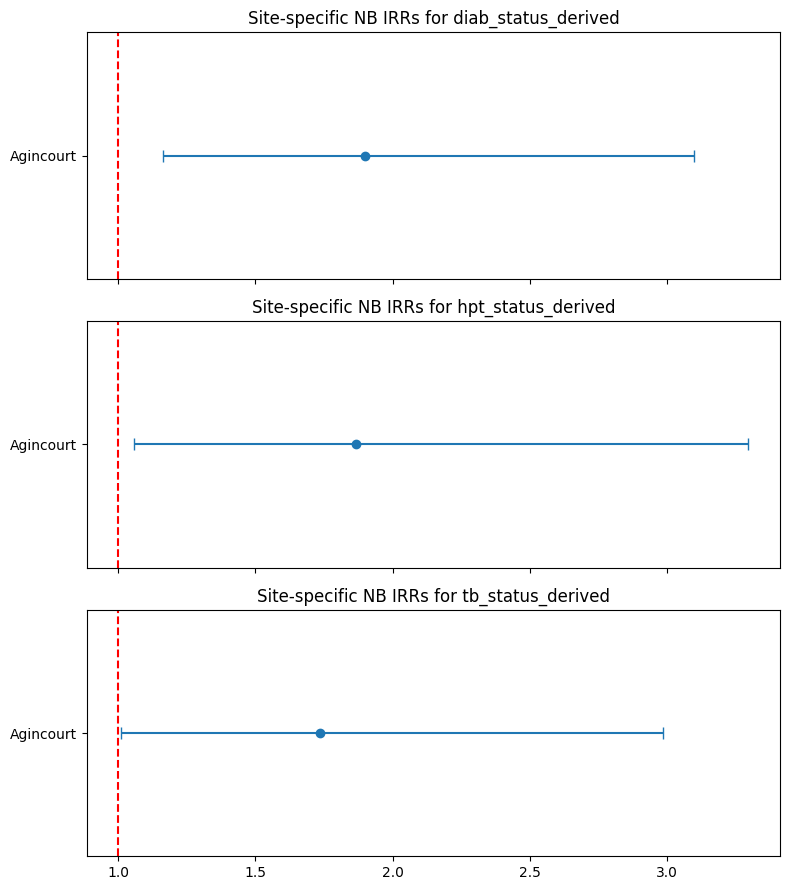

Saved forest plot: D:/APHRC/GoogleDrive_ii/stata_do_files/madiva/stroke_work/multiple_records/Agincourt_site_specific_nb_forest.png


In [143]:
# -----------------------------
# 8. Forest plot comparing site-specific NB IRRs for key predictors
# -----------------------------
# pull NB results for key predictors
rows = site_results_df[(site_results_df['Model'] == 'NegBinomial') &
                      (site_results_df['Variable'].isin(key_predictors))].copy()
# pivot for plotting
if not rows.empty:
    # convert IRR columns numeric
    rows['IRR'] = pd.to_numeric(rows['IRR'])
    rows['IRR_CI_lower'] = pd.to_numeric(rows['IRR_CI_lower'])
    rows['IRR_CI_upper'] = pd.to_numeric(rows['IRR_CI_upper'])

    # sort by variable, then site
    rows = rows.sort_values(['Variable', 'site'])
    # plot per predictor in separate subplots
    predictors = rows['Variable'].unique()
    nplots = len(predictors)
    fig, axes = plt.subplots(nplots, 1, figsize=(8, 3 * nplots), sharex=True)
    if nplots == 1:
        axes = [axes]
    for ax, pred in zip(axes, predictors):
        rr = rows[rows['Variable'] == pred].copy()
        y_pos = np.arange(len(rr))
        ax.errorbar(rr['IRR'], y_pos,
                    xerr=[rr['IRR'] - rr['IRR_CI_lower'], rr['IRR_CI_upper'] - rr['IRR']],
                    fmt='o', capsize=4)
        ax.axvline(1, color='red', linestyle='--')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(rr['site'])
        ax.set_title(f'Site-specific NB IRRs for {pred}')
        ax.invert_yaxis()
    plt.tight_layout()
    fig_path = os.path.join(output_dir, 'Agincourt_site_specific_nb_forest.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved forest plot: {fig_path}")
else:
    print("No site-specific NB results found for the requested key predictors.")

### Interpretive output

In [144]:
# -----------------------------
# 9. Short interpretive output (console)
# -----------------------------
print("\n--- Top pooled Negative Binomial IRRs ---")
pooled_nb = pooled_summ[pooled_summ['Model'] == 'NegBinomial'].copy()
pooled_nb = pooled_nb.sort_values('IRR', ascending=False)
print(pooled_nb[['Variable', 'IRR', 'IRR_CI_lower', 'IRR_CI_upper', 'p']].head(15))

# Done
print("\nAll done. Check Excel files and plots in:", output_dir)



--- Top pooled Negative Binomial IRRs ---
                   Variable       IRR  IRR_CI_lower  IRR_CI_upper             p
28       hpt_status_derived  2.054144      1.600499      2.636370  1.568402e-08
30      diab_status_derived  1.995374      1.611514      2.470670  2.338788e-10
35        tb_status_derived  1.822727      1.343812      2.472321  1.133650e-04
33       bmi_category_Obese  1.353372      0.754649      2.427110  3.099255e-01
27              tobacco_use  1.295829      1.018042      1.649414  3.527161e-02
25               sex_binary  1.102288      0.899424      1.350909  3.479954e-01
34       hiv_status_derived  0.946575      0.753920      1.188461  6.362941e-01
31      bmi_category_Normal  0.700744      0.548406      0.895399  4.463795e-03
32  bmi_category_Overweight  0.616866      0.475194      0.800776  2.847109e-04
26              alcohol_use  0.534128      0.384311      0.742348  1.885448e-04
29     obese_status_derived  0.506806      0.285090      0.900951  2.059647e-